<a href="https://colab.research.google.com/github/xxl5455/DS340/blob/main/DS340W.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
pip install haversine

  Using cached haversine-2.8.1-py2.py3-none-any.whl (7.7 kB)


In [3]:
pip install xgboost

ERROR: Operation cancelled by user


In [51]:
# Data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine, Unit

# Load the Citi-bike datasets

In [52]:
# loading the csv data to a Pandas DataFrame
data1904 = pd.read_csv('/content/drive/My Drive/DS340w/JC-201904-citibike-tripdata.csv')
data1905 = pd.read_csv('/content/drive/My Drive/DS340w/JC-201905-citibike-tripdata.csv')
data1906 = pd.read_csv('/content/drive/My Drive/DS340w/JC-201906-citibike-tripdata.csv')
data2004 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202004-citibike-tripdata.csv')
data2005 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202005-citibike-tripdata.csv')
data2006 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202006-citibike-tripdata.csv')
data2104 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202104-citibike-tripdata.csv')
data2105 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202105-citibike-tripdata.csv')
data2106 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202106-citibike-tripdata.csv')
data2204 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202204-citibike-tripdata.csv')
data2205 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202205-citibike-tripdata.csv')
data2206 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202206-citibike-tripdata.csv')
data2304 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202304-citibike-tripdata.csv')
data2305 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202305-citibike-tripdata.csv')
data2306 = pd.read_csv('/content/drive/My Drive/DS340w/JC-202306-citibike-tripdata.csv')

In [53]:
select_columns = ['starttime', 'stoptime', 'start station id', 'start station name', 'start station latitude', 'start station longitude', 'end station id', 'end station name', 'end station latitude', 'end station longitude', 'usertype', 'tripduration' ]
data1904 = data1904[select_columns]
data1905 = data1905[select_columns]
data1906 = data1906[select_columns]
data2004 = data2004[select_columns]
data2005 = data2005[select_columns]
data2006 = data2006[select_columns]

# Concatenate the selected data from all DataFrames into one
combined_df = pd.concat([data1904, data1905, data1906, data2004, data2005, data2006], ignore_index=True)

dataframes = [data2104, data2105, data2106, data2204, data2205, data2206, data2304, data2305, data2306]
columns_to_delete = ['ride_id', 'rideable_type']

# Iterate over the list of DataFrames and delete the column
for df in dataframes:
    df.drop(columns=columns_to_delete, inplace=True)

combined_df2 = pd.concat([data2104, data2105, data2106, data2204, data2205, data2206, data2304, data2305, data2306], ignore_index=True)
# Convert the start_time and end_time columns to datetime
combined_df2['started_at'] = pd.to_datetime(combined_df2['started_at'])
combined_df2['ended_at'] = pd.to_datetime(combined_df2['ended_at'])
combined_df2['duration in day'] = (combined_df2['ended_at'] - combined_df2['started_at'])

# Convert the duration to seconds
combined_df2['duration'] = combined_df2['duration in day'].dt.total_seconds()
del combined_df2['duration in day']

In [54]:
# Unify the column names of datasets
combined_df = combined_df.rename(columns={'starttime': 'started_at', 'stoptime': 'ended_at',
                                          'start station id':'start_station_id', 'start station name':'start_station_name',
                                          'start station latitude': 'start_lat', 'start station longitude': 'start_lng',
                                          'end station id':'end_station_id', 'end station name':'end_station_name',
                                          'end station latitude': 'end_lat', 'end station longitude': 'end_lng',
                                          'usertype': 'member_casual', 'tripduration': 'duration'})

# Unify the column types of datasets
# Convert datetime columns in combined_df to datetime
combined_df['started_at'] = pd.to_datetime(combined_df['started_at'])
combined_df['ended_at'] = pd.to_datetime(combined_df['ended_at'])

# Convert station ID columns in both DataFrames to object(string)
combined_df['start_station_id'] = combined_df['start_station_id'].astype(str)
combined_df['end_station_id'] = combined_df['end_station_id'].astype(str)
combined_df2['start_station_id'] = combined_df2['start_station_id'].astype(str)
combined_df2['end_station_id'] = combined_df2['end_station_id'].astype(str)


# Convert duration columns in combined_df2 to int
combined_df2['duration'] = combined_df2['duration'].astype(int)

In [55]:
# After aligning data types, you can perform the join
bike = pd.merge(combined_df, combined_df2, on=['started_at', 'ended_at', 'start_station_name', 'start_station_id',
                                               'end_station_name', 'end_station_id', 'start_lat', 'start_lng',
                                               'end_lat', 'end_lng', 'member_casual', 'duration'], how='outer')

In [56]:
bike.isnull().sum()

started_at               0
ended_at                 0
start_station_id         0
start_station_name      58
start_lat                0
start_lng                0
end_station_id           0
end_station_name      1885
end_lat               1262
end_lng               1262
member_casual            0
duration                 0
dtype: int64

In [57]:
bike = bike.dropna()
#checking nul values in each columns
bike.isnull().sum()
#Count unique values each columns
bike.nunique()

started_at            820167
ended_at              820830
start_station_id         282
start_station_name       228
start_lat              48982
start_lng              49829
end_station_id           507
end_station_name         430
end_lat                  516
end_lng                  516
member_casual              4
duration               12972
dtype: int64

In [58]:
# Remove extreme outliers, trip duration less than 1 minutes and more than 12 hours
bike = bike[(bike['duration'] <= 3600*12) & (bike['duration'] > 60)]

count    823922.000000
mean        884.795851
std        1565.513640
min          61.000000
25%         285.000000
50%         468.000000
75%         879.000000
max       43186.000000
Name: duration, dtype: float64


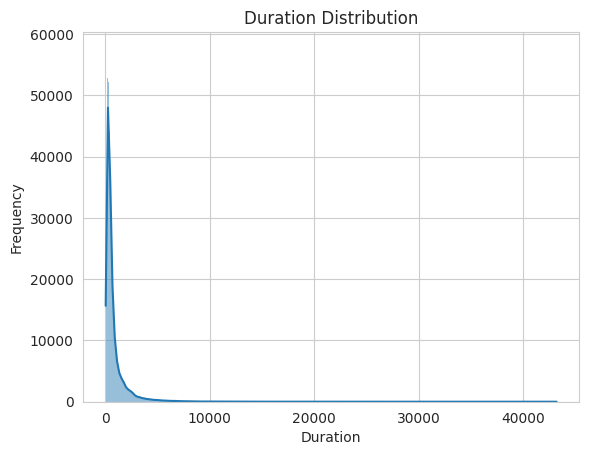

In [59]:
print(bike['duration'].describe())
# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Create the histogram
sns.histplot(bike['duration'], bins=1000, kde=True)  # 'kde' adds a Kernel Density Estimate line
plt.title('Duration Distribution')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.show()


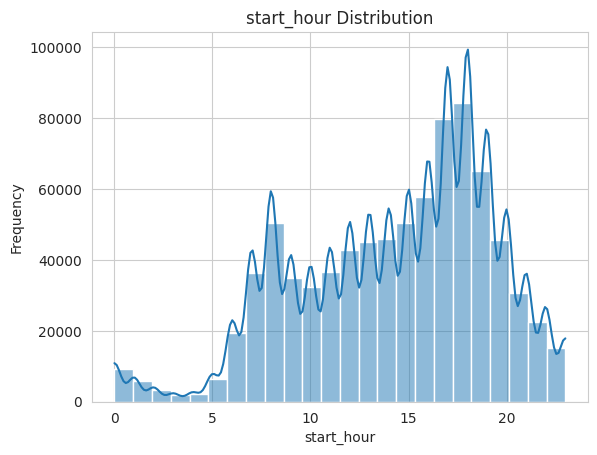

In [60]:
bike.loc[:, 'start_hour'] = bike['started_at'].dt.hour

# Create the histogram
sns.histplot(bike['start_hour'], bins=24, kde=True)  # 'kde' adds a Kernel Density Estimate line
plt.title('start_hour Distribution')
plt.xlabel('start_hour')
plt.ylabel('Frequency')
plt.show()

# Load the weather datasets

In [61]:
nycWeather = pd.read_csv('/content/drive/My Drive/DS340w/NYC_Central_Park_weather_1869-2022.csv')
nycWeather['DATE'] = pd.to_datetime(nycWeather['DATE'])

In [62]:
nycWeather['DATE'] = pd.to_datetime(nycWeather['DATE'])
weather = nycWeather[(nycWeather['DATE'].dt.year >= 2019) & (nycWeather['DATE'].dt.year <= 2022) &
                 (nycWeather['DATE'].dt.month.isin([4, 5, 6]))]
bike = bike[(bike['started_at'].dt.year <= 2022) & (bike['ended_at'].dt.year <= 2022)]

In [63]:
# Extract the date part from the 'started_at' column
bike.loc[:, 'start_date'] = bike['started_at'].dt.date
bike['start_date'] = pd.to_datetime(bike['start_date'])
combined_df = pd.merge(bike, weather, left_on='start_date', right_on='DATE')

In [64]:
combined_columns_to_delete = ['start_date', 'DATE']

# Drop the columns from the DataFrame
combined_df.drop(columns=combined_columns_to_delete, inplace=True)

In [65]:
combined_df

,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end_station_id,end_station_name,end_lat,end_lng,member_casual,duration,start_hour,PRCP,SNOW,SNWD,TMIN,TMAX
0,2019-04-01 07:48:04.754,2019-04-01 07:49:52.359,3183,Exchange Place,40.716247,-74.033459,3184,Paulus Hook,40.714145,-74.033552,Subscriber,107,7,0.0,0.0,0.0,33.0,46.0
1,2019-04-01 12:41:09.654,2019-04-01 12:49:23.029,3183,Exchange Place,40.716247,-74.033459,3187,Warren St,40.721124,-74.038051,Customer,493,12,0.0,0.0,0.0,33.0,46.0
2,2019-04-01 14:27:07.940,2019-04-01 14:35:40.937,3183,Exchange Place,40.716247,-74.033459,3202,Newport PATH,40.727224,-74.033759,Subscriber,512,14,0.0,0.0,0.0,33.0,46.0
3,2019-04-01 15:07:38.151,2019-04-01 15:10:54.626,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,-74.036486,Subscriber,196,15,0.0,0.0,0.0,33.0,46.0
4,2019-04-01 16:19:24.694,2019-04-01 16:27:08.645,3183,Exchange Place,40.716247,-74.033459,3273,Manila & 1st,40.721651,-74.042884,Subscriber,463,16,0.0,0.0,0.0,33.0,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557281,2022-06-11 21:09:13.000,2022-06-11 21:19:24.000,HB408,Marshall St & 2 St,40.740802,-74.042521,HB502,11 St & Washington St,40.749985,-74.027150,casual,611,21,0.0,0.0,0.0,66.0,74.0
557282,2022-06-11 17:16:07.000,2022-06-11 17:19:32.000,HB502,11 St & Washington St,40.749985,-74.027150,HB603,8 St & Washington St,40.745984,-74.028199,member,205,17,0.0,0.0,0.0,66.0,74.0
557283,2022-06-11 11:51:01.000,2022-06-11 12:00:54.000,HB502,11 St & Washington St,40.749985,-74.027150,HB301,4 St & Grand St,40.742258,-74.035111,casual,593,11,0.0,0.0,0.0,66.0,74.0
557284,2022-06-11 11:19:50.000,2022-06-11 11:21:36.000,JC076,Dixon Mills,40.721630,-74.049968,JC075,Monmouth and 6th,40.725685,-74.048790,member,106,11,0.0,0.0,0.0,66.0,74.0


In [66]:
combined_df.nunique()

started_at            547826
ended_at              547600
start_station_id         137
start_station_name        85
start_lat               1700
start_lng               1689
end_station_id           315
end_station_name         251
end_lat                  329
end_lng                  329
member_casual              4
duration               11146
start_hour                24
PRCP                      67
SNOW                       1
SNWD                       1
TMIN                      46
TMAX                      51
dtype: int64

In [67]:
# Since there were no snowing days, we deleted SNOW and SNWD columns
combined_columns_to_delete2 = ['SNOW', 'SNWD']
# Drop the columns from the DataFrame
combined_df.drop(columns=combined_columns_to_delete2, inplace=True)
# Normalize the member_casual
combined_df['member_casual'] = combined_df['member_casual'].replace({'Subscriber': 'member', 'Customer': 'casual'})

# Features Creation

In [68]:
#combined_df['member_casual'] = combined_df['member_casual'].replace({'member': '1', 'casual': '0'})
combined_df['member_casual'] = combined_df['member_casual'].map({'member': True, 'casual': False})

#It will convert weekday into number start at Monday=0 and end at Sunday=6.
combined_df['start_weekday'] = np.where(combined_df['started_at'].dt.weekday < 5, 1, 0)
combined_df['end_weekday'] = np.where(combined_df['ended_at'].dt.weekday < 5, 1, 0)

combined_df['member_casual']

0          True
1         False
2          True
3          True
4          True
          ...  
557281    False
557282     True
557283    False
557284     True
557285    False
Name: member_casual, Length: 557286, dtype: bool

In [69]:
# Define a function to calculate the distance
def calculate_distance(row):
    start_point = (row['start_lat'], row['start_lng'])
    end_point = (row['end_lat'], row['end_lng'])
    return haversine(start_point, end_point, unit=Unit.KILOMETERS)

# Apply the function to each row
combined_df['distance'] = combined_df.apply(calculate_distance, axis=1)

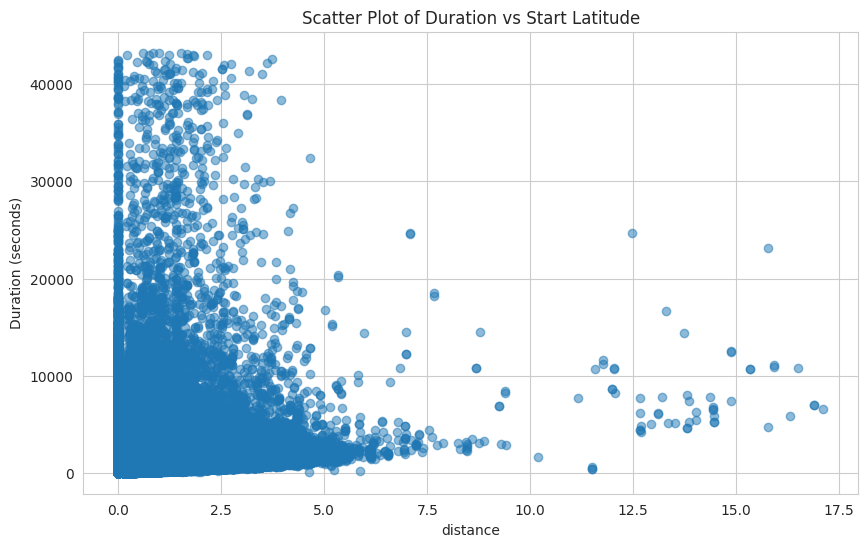

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 6))  # Set the size of the figure
plt.scatter(combined_df['distance'], combined_df['duration'], alpha=0.5)  # alpha sets the transparency
plt.title('Scatter Plot of Duration vs Start Latitude')  # Add a title
plt.xlabel('distance')  # Label the x-axis
plt.ylabel('Duration (seconds)')  # Label the y-axis
plt.show()

In [70]:
combined_df['speed_kmh'] = combined_df['distance'] / (combined_df['duration'] / 3600)
combined_df.loc[:, 'very_slow'] = combined_df['speed_kmh'] < 5
combined_df = combined_df [(combined_df['speed_kmh'] <= 40)]

In [ ]:
# Create the scatter plot
# plt.figure(figsize=(10, 6))  # Set the size of the figure
# plt.scatter(combined_df['speed_kmh'], combined_df['duration'], alpha=0.5)  # alpha sets the transparency
# plt.title('Scatter Plot of Duration vs Start Latitude')  # Add a title
# plt.xlabel('speed_kmh')  # Label the x-axis
# plt.ylabel('Duration (seconds)')  # Label the y-axis
# plt.show()

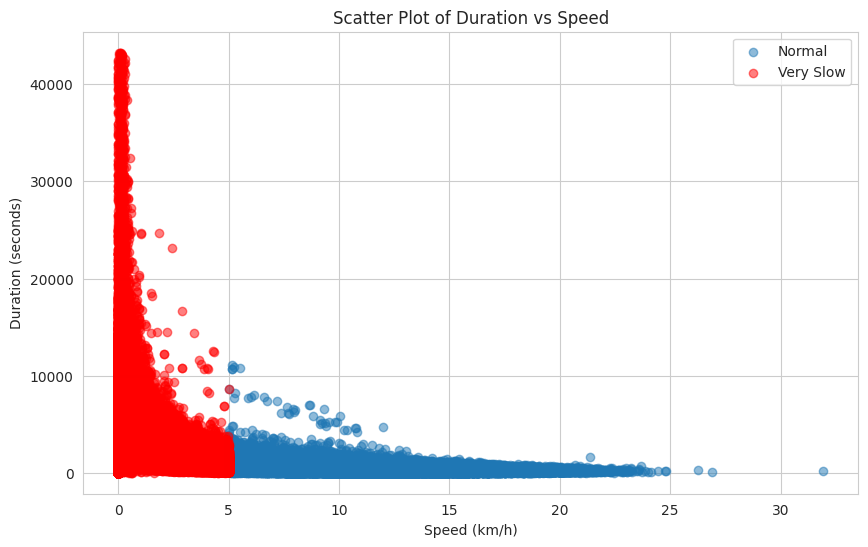

In [ ]:
plot_df = combined_df.copy()

plt.figure(figsize=(10, 6))
plt.scatter(plot_df[plot_df['very_slow'] == False]['speed_kmh'],
            plot_df[plot_df['very_slow'] == False]['duration'],
            alpha=0.5, label='Normal')
plt.scatter(plot_df[plot_df['very_slow'] == True]['speed_kmh'],
            plot_df[plot_df['very_slow'] == True]['duration'],
            alpha=0.5, color='red', label='Very Slow')
plt.title('Scatter Plot of Duration vs Speed')
plt.xlabel('Speed (km/h)')
plt.ylabel('Duration (seconds)')
plt.legend()
plt.show()


In [72]:
combined_df = combined_df.copy()
combined_df['log_duration'] = np.log1p(combined_df['duration'])
combined_df['log_speed'] = np.log1p(combined_df['speed_kmh'])
combined_df['reciprocal_speed'] = np.where(combined_df['speed_kmh'] != 0, 1 / combined_df['speed_kmh'], np.nan)
# # Create the scatter plot
# plt.figure(figsize=(10, 6))
# # plot not very_slow
# plt.scatter(combined_df[combined_df['very_slow'] == False]['log_speed'],
#             combined_df[combined_df['very_slow'] == False]['log_duration'],
#             alpha=0.5, label='Normal')
# # plot very_slow
# plt.scatter(combined_df[combined_df['very_slow'] == True]['log_speed'],
#             combined_df[combined_df['very_slow'] == True]['log_duration'],
#             alpha=0.5, color='red', label='Very Slow')
# plt.title('Scatter Plot of Duration vs Logarithm of Speed')
# plt.xlabel('Log(speed_kmh)')
# plt.ylabel('Duration (seconds)')
# plt.legend()
# plt.show()

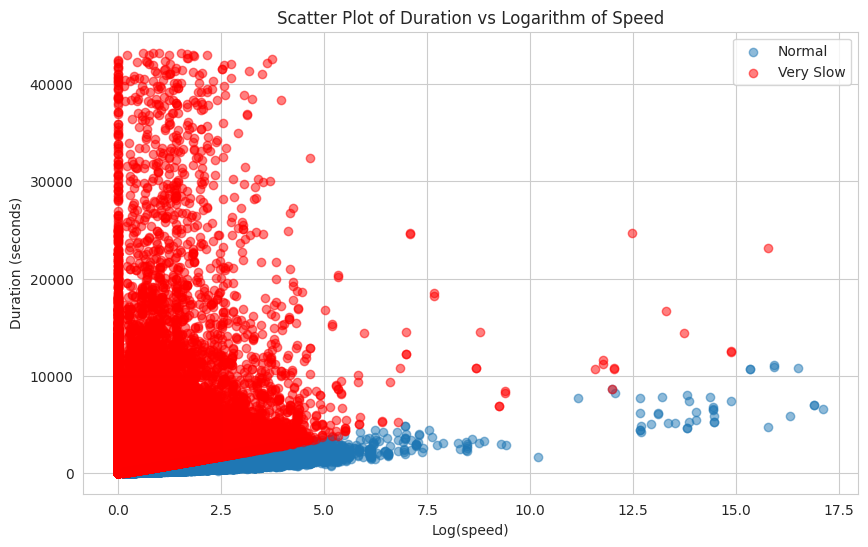

In [ ]:
plt.figure(figsize=(10, 6))
# plot not very_slow
plt.scatter(combined_df[combined_df['very_slow'] == False]['distance'],
            combined_df[combined_df['very_slow'] == False]['duration'],
            alpha=0.5, label='Normal')
# plot very_slow
plt.scatter(combined_df[combined_df['very_slow'] == True]['distance'],
            combined_df[combined_df['very_slow'] == True]['duration'],
            alpha=0.5, color='red', label='Very Slow')
plt.title('Scatter Plot of Duration vs Logarithm of Speed')
plt.xlabel('Log(speed)')  # x-axis
plt.ylabel('Duration (seconds)')  # y-axis
plt.legend()
plt.show()

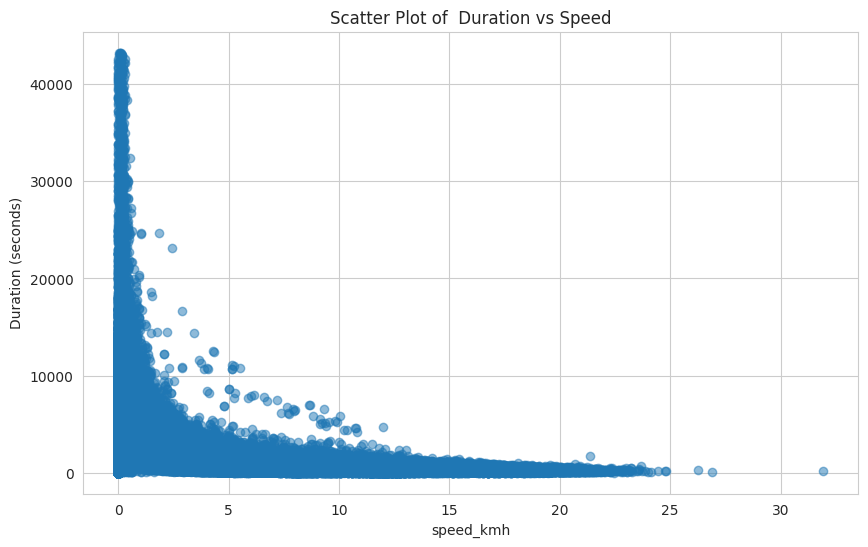

In [77]:
# Create the scatter plot
plt.figure(figsize=(10, 6))  # Set the size of the figure
plt.scatter(combined_df['speed_kmh'], combined_df['duration'], alpha=0.5)  # alpha sets the transparency
plt.title('Scatter Plot of  Duration vs Speed')  # Add a title
plt.xlabel('speed_kmh')  # Label the x-axis
plt.ylabel('Duration (seconds)')  # Label the y-axis
plt.show()

In [33]:
#Importing RFE and Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA

In [36]:
independent_variables=['start_hour',
                       'member_casual', 'log_speed', 'distance',
                       'PRCP', 'TMIN', 'TMAX', 'start_weekday', 'end_weekday', 'very_slow']

dependent_variables = 'log_duration'

# Create the data of independent variables
X = combined_df[independent_variables]

# Create the dependent variable data
y = combined_df[dependent_variables]

In [38]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# use PCA to transform longitude and latitude coordinates
# coords = np.vstack((X_train[['start_lat', 'start_lng']].values,
#                     X_train[['end_lat', 'end_lng']].values,
#                     X_test[['start_lat', 'start_lng']].values,
#                     X_test[['end_lat', 'end_lng']].values))

# pca = PCA().fit(coords)
# X_train['pickup_pca0'] = pca.transform(X_train[['start_lat', 'start_lng']])[:, 0]
# X_train['pickup_pca1'] = pca.transform(X_train[['start_lat', 'start_lng']])[:, 1]
# X_train['dropoff_pca0'] = pca.transform(X_train[['end_lat', 'end_lng']])[:, 0]
# X_train['dropoff_pca1'] = pca.transform(X_train[['end_lat', 'end_lng']])[:, 1]
# X_test['pickup_pca0'] = pca.transform(X_test[['start_lat', 'start_lng']])[:, 0]
# X_test['pickup_pca1'] = pca.transform(X_test[['start_lat', 'start_lng']])[:, 1]
# X_test['dropoff_pca0'] = pca.transform(X_test[['end_lat', 'end_lng']])[:, 0]
# X_test['dropoff_pca1'] = pca.transform(X_test[['end_lat', 'end_lng']])[:, 1]

In [ ]:
# city_long_border = (-74.09, -73.80)
# city_lat_border = (40.70, 40.85)
# N = 445828

# fig, ax = plt.subplots(ncols=2)
# ax[0].scatter(X_train['start_lng'].values[:N], X_train['start_lat'].values[:N],
#               color='blue', s=1, alpha=0.1)
# ax[1].scatter(X_train['pickup_pca0'].values[:N], X_train['pickup_pca1'].values[:N],
#               color='green', s=1, alpha=0.1)
# fig.suptitle('Pickup lat long coords and PCA transformed coords.')
# ax[0].set_ylabel('latitude')
# ax[0].set_xlabel('longitude')
# ax[1].set_xlabel('pca0')
# ax[1].set_ylabel('pca1')
# ax[0].set_xlim(city_long_border)
# ax[0].set_ylim(city_lat_border)
# pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
# ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
# ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
# plt.show()

# Linear Regression

In [39]:
# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
linear_reg =  LinearRegression()

#Aplly model on train dataset
linear_reg.fit(X_train, y_train)
#model score on train dataset
linear_reg.score(X_train, y_train)

0.7814711163927968

In [49]:
#predicted value of train and test dataset
y_pred_train = linear_reg.predict(X_train)
y_pred_test = linear_reg.predict(X_test)
#Train Data Evaluation Metrics
lr_train_mse  = mean_squared_error((y_train), (y_pred_train))
print("Train MSE :" , lr_train_mse)

lr_train_r2 = r2_score((y_train), (y_pred_train))
print("Train R2 :" ,lr_train_r2)

lr_train_r2_ = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",lr_train_r2_)
lr_test_mse  = mean_squared_error((y_test), (y_pred_test))
print("Test MSE :" , lr_test_mse)

lr_test_r2 = r2_score((y_test), (y_pred_test))
print("Test R2 :" ,lr_test_r2)

lr_test_r2_ = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ",lr_test_r2_)

Train MSE : 0.19053827392556924
Train R2 : 0.7814711163927968
Train Adjusted R2 :  0.7814662145538158
Test MSE : 0.1909441904665574
Test R2 : 0.7808721357050223
Test Adjusted R2 :  0.7808524732828146


# XGBOOST

In [41]:
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [43]:
# Create the XGBoost regression model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
#model score on train dataset
xgb_model.score(X_train, y_train)

0.8964042495501393

In [44]:
#predicted value of train and test dataset
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)
#Train Data Evaluation Metrics
XGB_train_mse  = mean_squared_error((y_train), (y_pred_train))
print("Train MSE :" , XGB_train_mse)

XGB_train_r2 = r2_score((y_train), (y_pred_train))
print("Train R2 :" ,XGB_train_r2)

XGB_train_r2_ = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",XGB_train_r2_)

XGB_test_mse  = mean_squared_error((y_test), (y_pred_test))
print("Test MSE :" , XGB_test_mse)

XGB_test_r2 = r2_score((y_test), (y_pred_test))
print("Test R2 :" ,XGB_test_r2)

XGB_test_r2_ = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ",XGB_test_r2_)

Train MSE : 0.09032652869915553
Train R2 : 0.8964042495501393
Train Adjusted R2 :  0.8964019257855209
Test MSE : 0.09247328370561952
Test R2 : 0.8938775088509174
Test Adjusted R2 :  0.8938679864415542


# Random Forest

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [46]:
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

random_forest_model.fit(X_train, y_train)

In [48]:
y_pred_train = random_forest_model.predict(X_train)
y_pred_test = random_forest_model.predict(X_test)

#Train Data Evaluation Metrics
rf_train_mse  = mean_squared_error((y_train), (y_pred_train))
print("Train MSE :" , rf_train_mse)

rf_train_r2 = r2_score((y_train), (y_pred_train))
print("Train R2 :" ,rf_train_r2)

rf_train_r2_ = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",rf_train_r2_)

rf_test_mse  = mean_squared_error((y_test), (y_pred_test))
print("Test MSE :" , rf_test_mse)

rf_test_r2 = r2_score((y_test), (y_pred_test))
print("Test R2 :" ,rf_test_r2)

rf_test_r2_ = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ",rf_test_r2_)

Train MSE : 0.06668201955932028
Train R2 : 0.9235222037507055
Train Adjusted R2 :  0.923520488271101
Test MSE : 0.09854357485234097
Test R2 : 0.8869112328339326
Test Adjusted R2 :  0.8869010853381125


In [78]:
combined_df

,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end_station_id,end_station_name,end_lat,end_lng,...,TMIN,TMAX,start_weekday,end_weekday,distance,speed_kmh,very_slow,log_duration,log_speed,reciprocal_speed
0,2019-04-01 07:48:04.754,2019-04-01 07:49:52.359,3183,Exchange Place,40.716247,-74.033459,3184,Paulus Hook,40.714145,-74.033552,...,33.0,46.0,1,1,0.233808,7.866443,False,4.682131,2.182274,0.127122
1,2019-04-01 12:41:09.654,2019-04-01 12:49:23.029,3183,Exchange Place,40.716247,-74.033459,3187,Warren St,40.721124,-74.038051,...,33.0,46.0,1,1,0.666206,4.864792,True,6.202536,1.768967,0.205559
2,2019-04-01 14:27:07.940,2019-04-01 14:35:40.937,3183,Exchange Place,40.716247,-74.033459,3202,Newport PATH,40.727224,-74.033759,...,33.0,46.0,1,1,1.220806,8.583792,False,6.240276,2.260073,0.116499
3,2019-04-01 15:07:38.151,2019-04-01 15:10:54.626,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,-74.036486,...,33.0,46.0,1,1,0.462810,8.500591,False,5.283204,2.251354,0.117639
4,2019-04-01 16:19:24.694,2019-04-01 16:27:08.645,3183,Exchange Place,40.716247,-74.033459,3273,Manila & 1st,40.721651,-74.042884,...,33.0,46.0,1,1,0.996004,7.744307,False,6.139885,2.168403,0.129127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557281,2022-06-11 21:09:13.000,2022-06-11 21:19:24.000,HB408,Marshall St & 2 St,40.740802,-74.042521,HB502,11 St & Washington St,40.749985,-74.027150,...,66.0,74.0,0,0,1.649046,9.716144,False,6.416732,2.371751,0.102921
557282,2022-06-11 17:16:07.000,2022-06-11 17:19:32.000,HB502,11 St & Washington St,40.749985,-74.027150,HB603,8 St & Washington St,40.745984,-74.028199,...,66.0,74.0,0,0,0.453581,7.965332,False,5.327876,2.193365,0.125544
557283,2022-06-11 11:51:01.000,2022-06-11 12:00:54.000,HB502,11 St & Washington St,40.749985,-74.027150,HB301,4 St & Grand St,40.742258,-74.035111,...,66.0,74.0,0,0,1.089942,6.616846,False,6.386879,2.030362,0.151129
557284,2022-06-11 11:19:50.000,2022-06-11 11:21:36.000,JC076,Dixon Mills,40.721630,-74.049968,JC075,Monmouth and 6th,40.725685,-74.048790,...,66.0,74.0,0,0,0.461722,15.681141,False,4.672829,2.814279,0.063771
